# <center> HOG and DAISY feature

In [1]:
import cv2 
import itertools
import numpy as np
from scipy.cluster.vq import kmeans,vq
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import operator
from functools import reduce
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from PIL import Image
from skimage.feature import hog, daisy

In [2]:
# from skimage import color 
def load_image(path):
    '''
    Read in a file and separate into L*a*b* channels
    '''
    #read in original image
    img = cv2.imread(path) 
    l, a, b = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2LAB))

    return l, a, b

def quantize_kmeans(a, b,ncolors, npics):
    lengthab = len(a) / npics
            
    # reshape matrix
    pixel = np.reshape((cv2.merge((a,b))),(len(a),2)).astype(float)
    
    # quantization
    kmeans = KMeans(n_clusters=ncolors) 
    label=kmeans.fit(pixel)
    return label.labels_

def label_to_color_map_fun(a,b,ncolors):
    w,h = np.shape(a)
    pixel = np.reshape((cv2.merge((a,b))),(w * h,2)).astype(float)
    centroids,_ = kmeans(pixel,ncolors)
    color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in centroids])}
    label_to_color_map = dict(zip(color_to_label_map.values(),color_to_label_map.keys()))
    return label_to_color_map

In [3]:
def train_xgb(files,ncolors,num_class, npics):
    
    kmap_a=np.array([])
    kmap_b=np.array([])
    for f in files:
        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])
    w,h = np.shape(a)
    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)
    
    pixel=[]
    for f in files:
        l, a, b = load_image(f)
        this_pixel = l.reshape(1,w*h).tolist()
        pixel.append(this_pixel[0])

    pixel = reduce(operator.add, pixel)

    pixel_mat = np.array(pixel).reshape(npics*w*h,1)

    dtrain = xgb.DMatrix(pixel_mat, label=label)
    param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
    num_round = 10
    print('Begin xgb training')
    bst = xgb.train(param, dtrain, num_round)
    return bst

In [4]:
def get_feature(file):
    test_color = Image.open(file,'r')
    test_color = test_color.convert('L') #makes it greyscale
    test_gray = np.asarray(test_color.getdata(),dtype=np.float64).reshape((test_color.size[1],test_color.size[0]))
    test_gray = np.asarray(test_gray,dtype=np.uint8) #if values still in range 0-255! 
    test_gray = Image.fromarray(test_gray,mode='L')
    
    # l(256,256)
    l, a, b = load_image(file)
    w,h = np.shape(a)
    # hog(256,256)
    fd, hog_image = hog(test_gray, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualise=True)
    # daisy(256,256,3)
    descs, descs_img = daisy(test_gray, step=180, radius=58, rings=2, histograms=6,
                             orientations=8, visualize=True)
    feature = np.zeros((256*256,5))
    feature[:,0] = hog_image.reshape(1,256*256)[0]
    feature[:,1] = descs_img[:,:,0].reshape(1,256*256)[0]
    feature[:,2] = descs_img[:,:,1].reshape(1,256*256)[0]
    feature[:,3] = descs_img[:,:,2].reshape(1,256*256)[0]
    feature[:,4] = l.reshape(1,256*256)[0]
    
    return(feature)

In [5]:
def train_xgb_fea(files,ncolors,num_class, npics):
    
    kmap_a=np.array([])
    kmap_b=np.array([])
    

    for f in files:
        _,a,b = load_image(f)
        kmap_a = np.concatenate([kmap_a, a.flatten()])
        kmap_b = np.concatenate([kmap_b, b.flatten()])

    label=quantize_kmeans(kmap_a, kmap_b, ncolors, npics)
    w,h = np.shape(a)
        
    pixel_feature = np.zeros(shape=(w*h*npics,5))
    

    
    for ind,f in enumerate(files):
        feature = get_feature(f)
        pixel_feature[(w*h*ind):(w*h*(ind+1)),:] = feature

    dtrain = xgb.DMatrix(pixel_feature, label=label)
    param = {'max_depth':10, 'eta':0.1, 'silent':1, 'objective':'multi:softmax', 'num_class':num_class}
    num_round = 10
    print('Begin xgb training')
    bst = xgb.train(param, dtrain, num_round)
    return bst

In [6]:
def test_xgb_fea(file,xgb_model):
        
    pixel_feature = get_feature(file)

    dtest=xgb.DMatrix(pixel_feature)
    preds = xgb_fit.predict(dtest)

    return preds

## load train image

In [7]:
folder_dir = './girl/'
train_dir = []

for filename in os.listdir(folder_dir):
    if filename.startswith('.') or \
    filename.startswith('predict') or \
    filename.startswith('gray'): 
        continue
    train_dir.append(folder_dir + filename)

# train_dir = ['WechatIMG1667.jpeg']

In [11]:
ncolors = 16
kmap_a=np.array([])
kmap_b=np.array([])
for f in train_dir:
    _,a,b = load_image(f)
    kmap_a = np.concatenate([kmap_a, a.flatten()])
    kmap_b = np.concatenate([kmap_b, b.flatten()])
h,w = np.shape(a)

In [12]:
npics = len(train_dir) # number of train image
kmap_a = kmap_a.reshape(npics*w*h,1)
kmap_b = kmap_b.reshape(npics*w*h,1)
label_to_color_map = label_to_color_map_fun(kmap_a,kmap_b,ncolors)
print(len(label_to_color_map))
ncolors = len(label_to_color_map) # update ncolors

15


## train xgboost model

In [13]:
xgb_fit = train_xgb_fea(train_dir,ncolors,ncolors,npics)

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Begin xgb training


In [14]:
test_img = './girl/gray/WechatIMG1286_gray.jpg'
preds = test_xgb_fea(test_img, xgb_fit)

/usr/local/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
def pred2color(test_img,preds,label_to_color_map,ncolors=16, saveimg = False, savename = 'test.jpg'):
    l_test, a_test, b_test = load_image(test_img)
    preds = preds.reshape(h,w)
    print(w,h)
    colors_present = [i for i in range(ncolors)]
    output_a = np.zeros((h,w))
    output_b = np.zeros((h,w))
    output_l = l_test.reshape((h,w))
    for i in range(h):
        for j in range(w):
            a,b = label_to_color_map[colors_present[int(preds[i,j])]]
            output_a[i,j] = a
            output_b[i,j] = b
    print(output_a.shape,output_b.shape,output_l.shape)
    output_img = cv2.cvtColor(cv2.merge(( np.uint8(output_l), np.uint8(output_a), np.uint8(output_b))),
                              cv2.COLOR_LAB2RGB)
    if saveimg == True:
        plt.imsave('./girl/predict/' + savename,output_img)    
    return(output_img)

256 256
(256, 256) (256, 256) (256, 256)


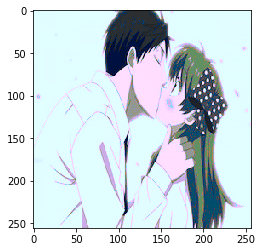

In [16]:
output_img = pred2color(test_img,preds,label_to_color_map,ncolors=ncolors,
                        saveimg = False, savename = 'wenzhu.jpg')
plt.imshow(output_img)
# cv2.imwrite('savename.jpg', output_img )
# plt.imsave('./girl/predict/output_img_gile12.jpg',output_img)

# convert rgb to gray image

In [77]:
def savegray(path, saveimg = False, savename = 'gray.jpg'):
    img = cv2.imread(path) 
    gray = img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    if saveimg == True:
        cv2.imwrite(savename, img )
    return(gray)

(256, 256)

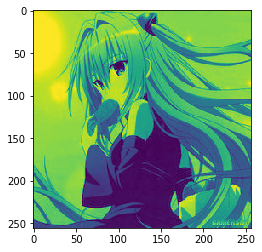

In [78]:
gray_test = savegray('./girl/WechatIMG1284.jpg', saveimg = True, savename = './girl/gray/WechatIMG1284_gray.jpg')
plt.imshow(gray_test)
gray_test.shape